In [40]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [41]:
#Data paths
data_dir_train = 'data/Training data'
data_dir_val = 'data/Validation data'
data_dir_test = 'data/Test data'

In [42]:
#Module parametres
batch_size = 32
img_height = 180
img_width = 180

In [43]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size)
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6238 files belonging to 4 classes.
Found 400 files belonging to 4 classes.
Found 977 files belonging to 4 classes.


In [44]:
class_names = train_ds.class_names
print(class_names)

['Elephant', 'Panda', 'Tiger', 'Zebra']


In [45]:

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [46]:
#Standarize data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [47]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [54]:
num_classes = len(class_names)

model = Sequential([
 # layers.BatchNormalization(input_shape=(img_height, img_width, 3)),
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (None, 180, 180, 3)      12        
 hNormalization)                                                 
                                                                 
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)       

In [56]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
195/195 [==============================] - 128s 642ms/step - loss: 0.9435 - accuracy: 0.6012 - val_loss: 1.5156 - val_accuracy: 0.4375
Epoch 2/15
195/195 [==============================] - 128s 656ms/step - loss: 0.5763 - accuracy: 0.7740 - val_loss: 0.8973 - val_accuracy: 0.6625
Epoch 3/15
195/195 [==============================] - 129s 661ms/step - loss: 0.4841 - accuracy: 0.8148 - val_loss: 1.0541 - val_accuracy: 0.6575
Epoch 4/15
195/195 [==============================] - 130s 666ms/step - loss: 0.4227 - accuracy: 0.8355 - val_loss: 0.9194 - val_accuracy: 0.7200
Epoch 5/15
195/195 [==============================] - 78s 397ms/step - loss: 0.3962 - accuracy: 0.8520 - val_loss: 0.9393 - val_accuracy: 0.6950
Epoch 6/15
195/195 [==============================] - 70s 359ms/step - loss: 0.3560 - accuracy: 0.8690 - val_loss: 0.7142 - val_accuracy: 0.7850
Epoch 7/15
195/195 [==============================] - 69s 356ms/step - loss: 0.3561 - accuracy: 0.8689 - val_loss: 0.7903 - va

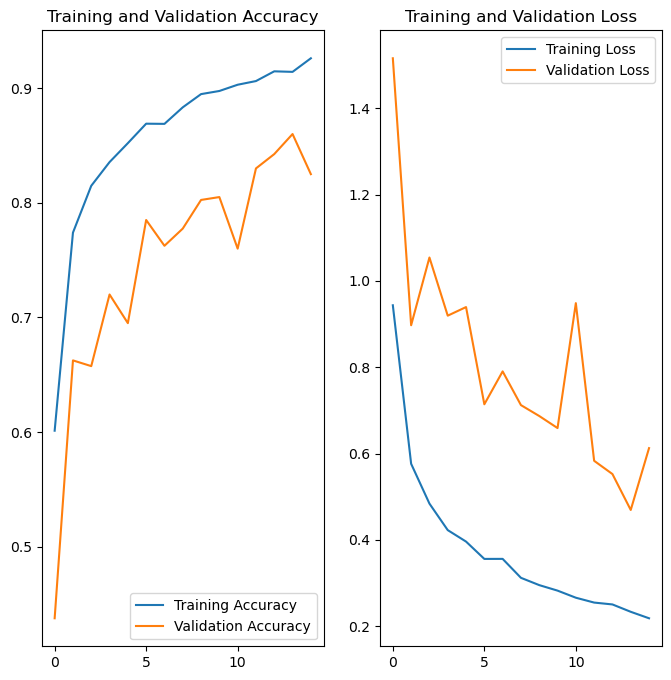

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [58]:
#Testing model on test data
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy:', accuracy)

31/31 [==============================] - 2s 76ms/step - loss: 0.5191 - accuracy: 0.8485
Test accuracy: 0.8485158681869507


In [61]:
model.save('model4a.h5')

In [1]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
import tensorflow as tf
import numpy as np
# Inicjalizacja GUI
root = tk.Tk()

# Funkcja do wczytywania obrazu i dokonywania predykcji
def predict_image():
    file_path = filedialog.askopenfilename()
    img = tf.keras.utils.load_img(
    file_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    image = Image.open(file_path).resize((img_width, img_height))
    image = image.convert("RGB")
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)

    # Tworzenie nowego okna dla wyświetlenia wyników
    result_window = tk.Toplevel(root)
    result_window.title("Prediction Result")

    # Wyświetlanie przewidywanego gatunku zwierzęcia
    class_label_text = "Predicted Class: {}".format(class_names[np.argmax(score)])
    class_label_label = tk.Label(result_window, text=class_label_text)
    class_label_label.pack()

    # Wyświetlanie pewności predykcji
    confidence_text = "Confidence: {:.2f}%".format(100 * np.max(score))
    confidence_label = tk.Label(result_window, text=confidence_text)
    confidence_label.pack()

    # Wyświetlanie wczytanego obrazu
    image_display = ImageTk.PhotoImage(Image.open(file_path).resize((300, 300)))
    image_label = tk.Label(result_window, image=image_display)
    image_label.image = image_display
    image_label.pack()

# Przycisk do wczytywania obrazu
upload_button = tk.Button(root, text="Upload Image", command=predict_image)
upload_button.pack()

# Uruchomienie GUI
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\kaboo\AppData\Local\Temp\ipykernel_21332\753451396.py", line 13, in predict_image
    file_path, target_size=(img_height, img_width)
NameError: name 'img_height' is not defined
